In [1]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multitag_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle
import json

In [2]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
exps_done=0
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        if df_all is None:
            df_all=_df
        else:
            _df["Run Exp Num"]=exps_done
            df_all = pd.concat([df_all, _df], ignore_index=True)
    exps_done=len(df_all["Run Exp Num"].unique())
    # print(exps_done, df_all["Run Exp Num"].unique())
df_all

0.df
1.df
2.df
3.df
4.df
5.df
6.df
7.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,1.763509e+09,1.763509e+09,"[345.35, 85.26, 81.06, 85.18, 82.06, 82.06, 85...",775,0,5
1,3,1,1.763509e+09,1.763509e+09,"[1275.62, 30.86, 28.88, 31.24, 29.49, 29.79, 3...",775,0,5
2,4,1,1.763509e+09,1.763509e+09,"[1305.29, 28.42, 28.73, 28.73, 28.27, 28.04, 2...",775,0,5
3,5,1,1.763509e+09,1.763509e+09,"[162.62, 13.24, 13.16, 12.78, 13.39, 12.7, 13....",775,0,5
4,1,2,1.763509e+09,1.763509e+09,"[184.82, 17.59, 17.59, 17.59, 17.51, 17.66, 17...",775,0,5
...,...,...,...,...,...,...,...,...
3675,5,4,1.763512e+09,1.763512e+09,"[8.74, 8.13, 8.2, 8.13, 7.97, 8.13, 8.13, 8.05...",995,7,5
3676,1,5,1.763512e+09,1.763512e+09,"[24.22, 27.5, 26.82, 26.44, 27.66, 26.59, 26.8...",995,7,5
3677,2,5,1.763512e+09,1.763512e+09,"[41.24, 47.19, 48.79, 47.19, 47.65, 48.49, 47....",995,7,5
3678,3,5,1.763512e+09,1.763512e+09,"[76.56, 101.89, 101.66, 101.89, 101.66, 103.19...",995,7,5


In [3]:
with open("../tag_name_mapping.json", 'r') as f:
    tag_name_mapping=json.load(f)
tag_name_mapping

{'Tag1': 'v32-4',
 'Tag2': 'v32-5',
 'Tag3': 'v31-2',
 'Tag4': 'v31-1',
 'Tag5': 'v32-3'}

In [4]:
# time_per_phase = 10/1000  # s
# num_phases=6
# num_mpps=df_all.iloc[0]['NumMPPs']
# sampling_rate=1000
# plotting=False
# ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

# processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
#                                 "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
# processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])



# unique_exp_no=0
# phase_order=[1,3,4,6,7,8]

# for df_idx in range(len(df_all)):

#     voltages=df_all.iloc[df_idx]['Voltages (mV)']
#     phase_medians={
#         1:[],
#         3:[],
#         4:[],
#         6:[],
#         7:[],
#         8:[],
#     }
#     if plotting:
#         plt.figure(figsize=(15,5))
#     for idx,v in enumerate(ver_lines):
#         if idx<len(ver_lines)-1:
#             phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
#         if plotting:
#             # plt.subplot(len(df_all)//3+1, 3, df_idx+1)
#             if idx%num_phases==0:
#                 plt.axvline(x=v, color='b', linestyle='-')
#             else:
#                 plt.axvline(x=v, color='r', linestyle='--')
#     entry={
#         "Rx": df_all.iloc[df_idx]["Rx"],
#         "Tx":df_all.iloc[df_idx]["Tx"],
#         "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
#         "Phase1":phase_medians[1],
#         "Phase3":phase_medians[3],
#         "Phase4":phase_medians[4],
#         "Phase6":phase_medians[6],
#         "Phase7":phase_medians[7],
#         "Phase8":phase_medians[8],
#         "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
#         "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
#         "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
#     }
#     for phase in phase_order:
#         entry_aggregated={
#             "Rx":df_all.iloc[df_idx]["Rx"],
#             "Tx":df_all.iloc[df_idx]["Tx"],
#             "phase": str(phase),
#             "median": np.mean(phase_medians[phase]), # mean of medians
#             "std": np.std(phase_medians[phase]),
#             "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
#             'delta': max(phase_medians[phase])-min(phase_medians[phase]),
#             "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
#             "Unique Exp Number":unique_exp_no,
#             "allVoltages": phase_medians[phase]
#         }
#         processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
#     unique_exp_no+=1
    
#     # # Identify and print bad MPPs
#     # bad=False
#     # for k in phase_medians.keys():
#     #     assert(len(phase_medians[k])==num_mpps)
#     #     if np.std(phase_medians[k])>1:
#     #         print(f"<== Bad data found at {df_idx} df_idx at phase {k}.", end="\t")
#     #         print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
#     #         bad=True
#     # if bad and plotting:
#     #     plt.plot(voltages,'.')
#     #     plt.title(df_idx)
#     #     plt.tight_layout()
#     #     plt.ylim([np.percentile(voltages, 1), np.percentile(voltages, 99)])
#     #     plt.savefig(f"badplots/{df_idx}.pdf")
#     #     plt.clf()
#     # elif not bad and plotting:
#     #     plt.clf()
    
    
#     processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    
    
#     # if df_idx>20:
#     #     break   
# # if plotting:
# #     plt.show()
    
with open("processedDF.pkl", 'rb') as f:
    processedDF=pickle.load(f)
    
with open("processedDF_aggregated.pkl", 'rb') as f:
    processedDF_aggregated=pickle.load(f)


In [5]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,"[345.35, 85.26, 81.06, 85.18, 82.06, 82.06, 85...","[85.18, 84.08, 83.53999999999999, 84.305, 83.47]","[83.16499999999999, 81.86500000000001, 81.56, ...","[81.33000000000001, 81.485, 82.17, 80.3, 81.405]","[79.35, 78.13, 80.225, 78.925, 78.7]","[77.86, 76.64, 77.71000000000001, 77.63, 77.215]","[74.81, 73.73500000000001, 74.385, 73.82, 73.89]",775,0,5
1,3,1,"[1275.62, 30.86, 28.88, 31.24, 29.49, 29.79, 3...","[30.71, 29.945, 30.060000000000002, 30.29, 30.25]","[30.1, 29.72, 29.64, 30.29, 29.605]","[30.325, 29.564999999999998, 29.64, 30.02, 29.72]","[29.335, 29.715000000000003, 28.95, 29.64, 29....","[29.064999999999998, 29.64, 29.375, 29.525, 29...","[29.145000000000003, 29.07, 29.41, 29.565, 29.95]",775,0,5
2,4,1,"[1305.29, 28.42, 28.73, 28.73, 28.27, 28.04, 2...","[28.57, 28.5, 28.61, 29.715, 28.575]","[28.46, 28.46, 28.57, 29.715, 28.305]","[28.27, 28.04, 28.23, 28.42, 28.42]","[27.77, 27.695, 27.275, 27.58, 27.085]","[27.085, 27.12, 27.045, 27.545, 27.125]","[26.82, 26.74, 26.855, 26.705, 26.74]",775,0,5
3,5,1,"[162.62, 13.24, 13.16, 12.78, 13.39, 12.7, 13....","[13.16, 13.01, 12.934999999999999, 13.58, 12.78]","[13.31, 13.16, 13.01, 13.24, 13.235]","[13.31, 13.120000000000001, 13.350000000000001...","[13.47, 13.350000000000001, 13.31, 13.50499999...","[13.579999999999998, 13.92, 13.54, 13.85, 13.47]","[13.465, 13.31, 13.275, 13.235, 13.35000000000...",775,0,5
4,1,2,"[184.82, 17.59, 17.59, 17.59, 17.51, 17.66, 17...","[17.59, 17.51, 17.59, 17.51, 17.66]","[17.97, 17.93, 17.97, 17.93, 17.89]","[13.275, 13.16, 13.24, 13.24, 13.275]","[15.945, 15.98, 15.98, 16.06, 16.02]","[17.43, 17.36, 17.43, 17.36, 17.43]","[17.97, 18.155, 17.97, 17.89, 17.89]",775,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3675,5,4,"[8.74, 8.13, 8.2, 8.13, 7.97, 8.13, 8.13, 8.05...","[8.13, 8.239999999999998, 8.13, 8.2, 8.01]","[8.13, 8.315, 8.01, 8.39, 8.465]","[7.705, 8.084999999999999, 8.2, 8.81, 7.975000...","[8.625, 8.850000000000001, 8.469999999999999, ...","[8.13, 8.2, 8.28, 8.239999999999998, 8.2]","[8.239999999999998, 8.315, 8.545, 8.315, 8.315]",995,7,5
3676,1,5,"[24.22, 27.5, 26.82, 26.44, 27.66, 26.59, 26.8...","[26.67, 26.67, 26.895000000000003, 26.665, 26....","[27.315, 26.700000000000003, 26.44, 26.745, 27...","[27.125, 26.55, 26.97, 26.59, 27.28]","[27.045, 26.630000000000003, 26.44, 26.78, 27.12]","[26.895, 26.97, 26.895, 26.855, 26.78]","[26.705, 26.74, 27.05, 26.97, 27.16]",995,7,5
3677,2,5,"[41.24, 47.19, 48.79, 47.19, 47.65, 48.49, 47....","[47.65, 49.36, 48.905, 48.865, 48.41]","[48.635000000000005, 47.76, 49.209999999999994...","[48.26, 49.515, 48.18, 49.55, 47.185]","[49.745000000000005, 49.17, 48.519999999999996...","[48.675, 48.49, 50.47, 49.86, 49.135]","[49.29, 49.745, 48.715, 48.41, 47.955]",995,7,5
3678,3,5,"[76.56, 101.89, 101.66, 101.89, 101.66, 103.19...","[101.89, 102.43, 102.88499999999999, 102.77, 1...","[103.15, 102.195, 102.12, 102.35, 102.69]","[101.93, 101.015, 101.16999999999999, 102.2, 1...","[102.35, 102.35, 101.51, 102.58, 101.28]","[102.73, 102.81, 102.96000000000001, 102.81, 1...","[102.69, 105.785, 103.19, 102.465, 102.31]",995,7,5


In [6]:
with open("processedDF_aggregated.pkl", 'wb') as f:
    pickle.dump(processedDF_aggregated,f)
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,2,1,1,84.115,0.619387,775000000.0,NaN,1.710,0,0,"[85.18, 84.08, 83.53999999999999, 84.305, 83.47]"
1,2,1,3,82.285,0.595710,775000000.0,NaN,1.605,0,0,"[83.16499999999999, 81.86500000000001, 81.56, ..."
2,2,1,4,81.338,0.599305,775000000.0,NaN,1.870,0,0,"[81.33000000000001, 81.485, 82.17, 80.3, 81.405]"
3,2,1,6,79.066,0.700553,775000000.0,NaN,2.095,0,0,"[79.35, 78.13, 80.225, 78.925, 78.7]"
4,2,1,7,77.411,0.440867,775000000.0,NaN,1.220,0,0,"[77.86, 76.64, 77.71000000000001, 77.63, 77.215]"
...,...,...,...,...,...,...,...,...,...,...,...
22075,4,5,3,143.571,0.345925,995000000.0,NaN,0.955,7,3679,"[143.78, 143.51, 143.28, 144.12, 143.165000000..."
22076,4,5,4,142.931,0.407436,995000000.0,NaN,1.105,7,3679,"[142.98000000000002, 142.595, 142.75, 143.7, 1..."
22077,4,5,6,142.940,0.313560,995000000.0,NaN,0.880,7,3679,"[142.79, 142.79, 142.67000000000002, 143.55, 1..."
22078,4,5,7,143.137,0.439768,995000000.0,NaN,1.070,7,3679,"[142.78500000000003, 142.71, 143.55, 143.78, 1..."


In [7]:
processedDF_aggregated[processedDF_aggregated["Experiment Number"]==1]

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
2760,2,1,1,71.908,1.521189,775000000.0,NaN,4.240,1,460,"[74.58, 70.34, 70.80000000000001, 71.300000000..."
2761,2,1,3,71.031,0.950797,775000000.0,NaN,2.865,1,460,"[70.725, 71.565, 69.58000000000001, 72.445, 70..."
2762,2,1,4,69.864,1.915039,775000000.0,NaN,5.880,1,460,"[70.23, 70.38, 72.255, 70.08, 66.375]"
2763,2,1,6,66.834,1.704651,775000000.0,NaN,4.960,1,460,"[67.485, 69.39, 67.28999999999999, 64.43, 65.575]"
2764,2,1,7,65.767,1.368110,775000000.0,NaN,3.815,1,460,"[65.195, 67.03, 65.535, 67.445, 63.63]"
...,...,...,...,...,...,...,...,...,...,...,...
5515,4,5,3,135.675,0.121573,995000000.0,NaN,0.340,1,919,"[135.65, 135.73000000000002, 135.575, 135.54, ..."
5516,4,5,4,138.307,0.227917,995000000.0,NaN,0.690,1,919,"[138.015, 138.21, 138.70499999999998, 138.36, ..."
5517,4,5,6,138.496,0.170716,995000000.0,NaN,0.460,1,919,"[138.51, 138.665, 138.66500000000002, 138.435,..."
5518,4,5,7,138.056,0.063356,995000000.0,NaN,0.150,1,919,"[138.13, 137.98, 138.095, 138.095, 137.98]"


In [8]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, selected_experiments_all = multitag_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False, all_available_tags=["1", "2", "3", "4", "5"], tag_name_mappings=tag_name_mapping)

# with open("no_correction_all_errs.pkl",'wb') as f:
#     pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

# with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
#     pickle.dump(all_freqs_unwrapped,f)    

# with open("theoretical_phase.pkl",'wb') as f:
#     pickle.dump(all_freqs_theoretical,f)    

In [9]:
all_freqs[915e6][1][0]['1-2']

2.3826993514249226

In [10]:
def getMPPSignalPlot(exp_no, tag1, tag2, freq):
    # freq in mhz
    plt.subplot(2,1,1)
    plt.plot(processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag1) & (processedDF['Tx']==tag2) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0])
    plt.title(f"Rx={tag1}, Tx={tag2}")
    
    plt.subplot(2,1,2)
    v=processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag2) & (processedDF['Tx']==tag1) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0]
    plt.plot(v)
    plt.ylim([np.percentile(v,1), np.percentile(v,99)])
    plt.title(f"Rx={tag2}, Tx={tag1}")
    
    plt.suptitle(f"Exp={exp_no}, freq={freq}")
    plt.tight_layout()
    plt.show()

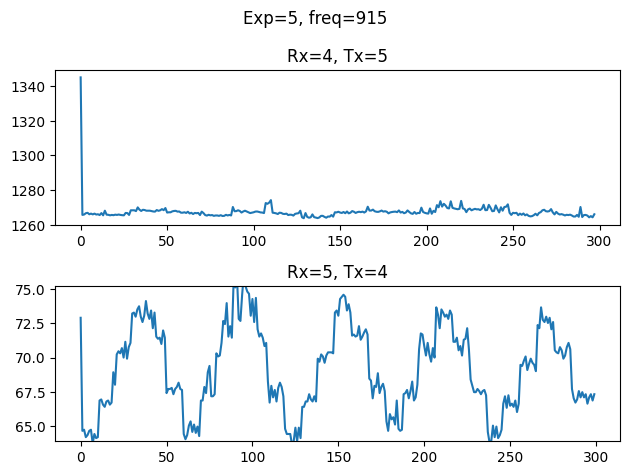

In [11]:
getMPPSignalPlot(5, 4, 5, 915)

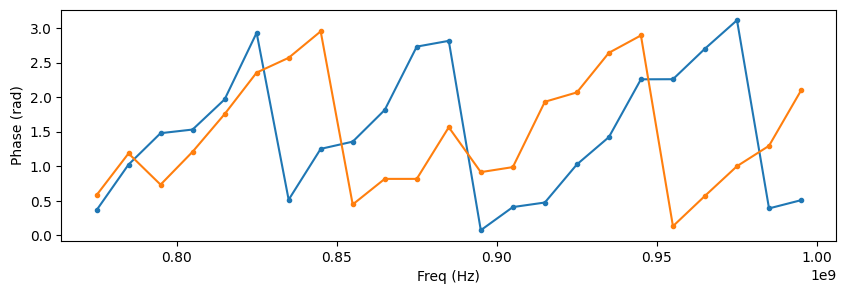

In [12]:
plt.figure(figsize=(10,3))
link1='1-5'
link2='4-5'
l1_ph=[]
l2_ph=[]
for freq in all_freqs.keys():
    exp1=4
    exp2=7
    l1_ph.append(all_freqs[freq][exp1][0][link1])
    l2_ph.append(all_freqs[freq][exp2][0][link2])
    
plt.plot(list(all_freqs.keys()),l1_ph, '.-', label="1-5, exp 0")
plt.plot(list(all_freqs.keys()),l2_ph, '.-', label="4-5, exp 0")
plt.xlabel("Freq (Hz)")
plt.ylabel("Phase (rad)")
plt.show()
# what is the relation between phase change and t2t distance.............
# get distance matrix from slam info
# ability to plot adc voltages for given experiment number and frequency.

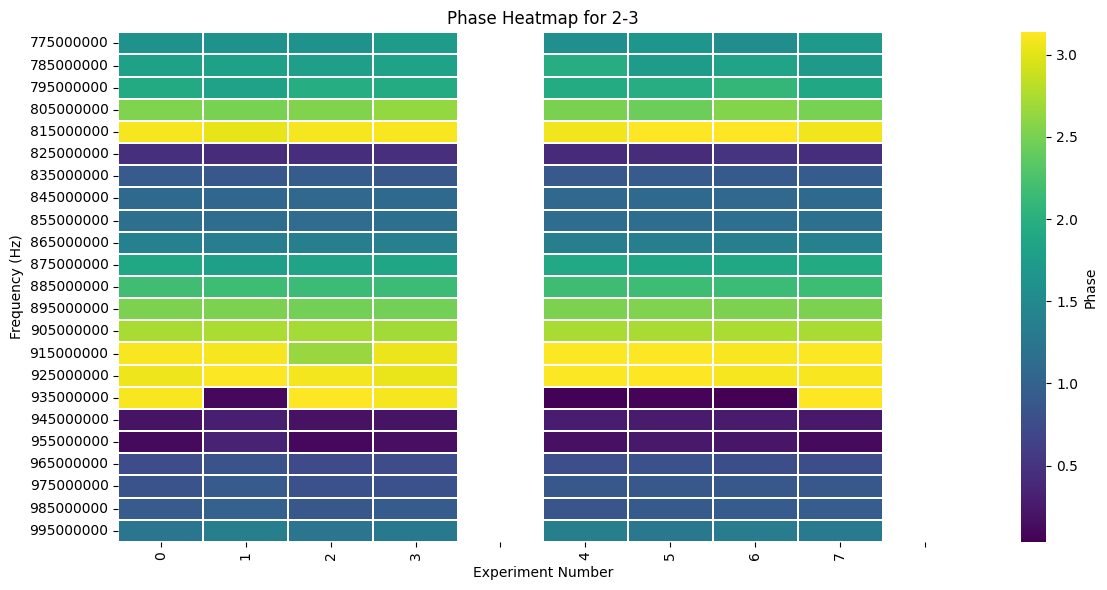

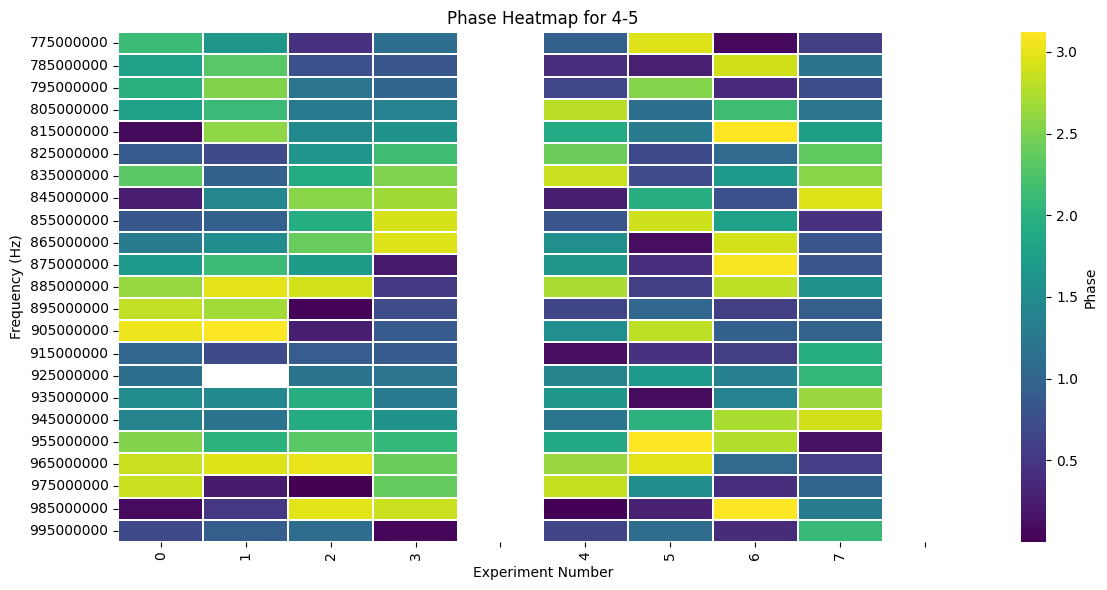

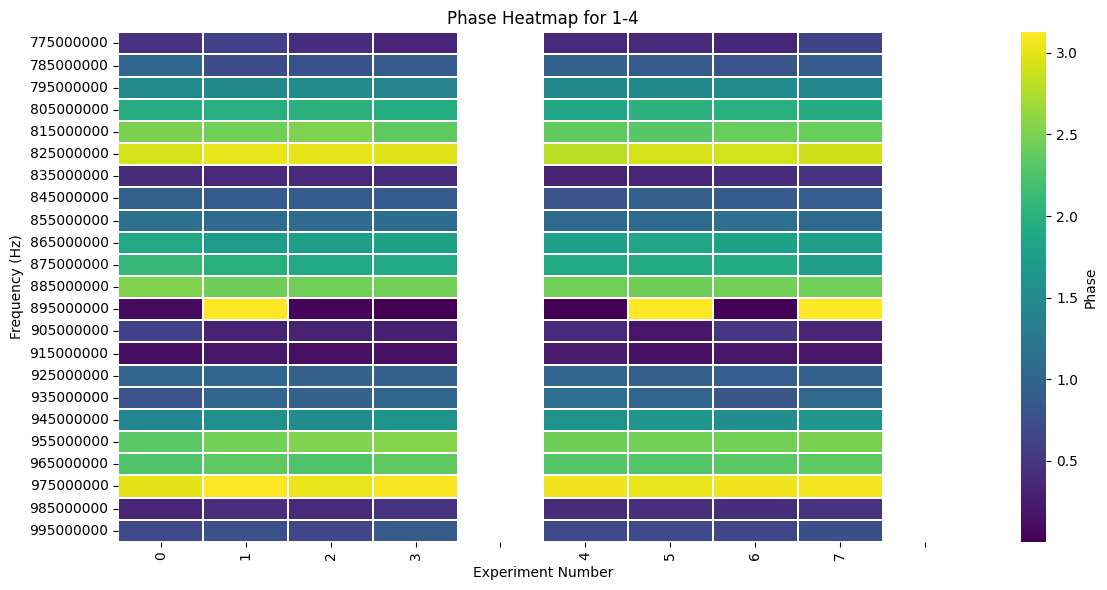

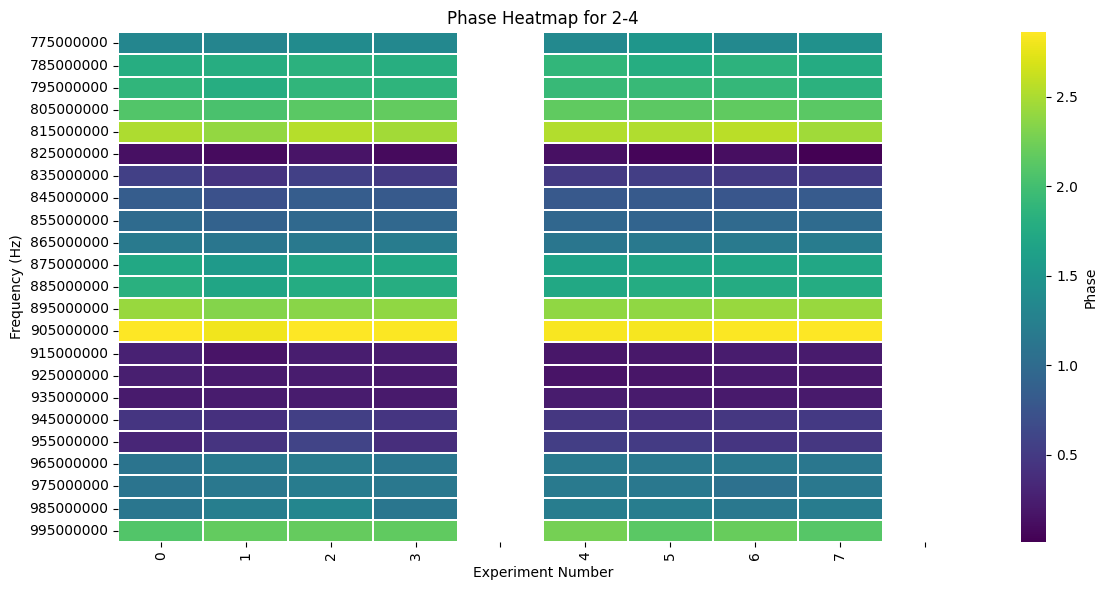

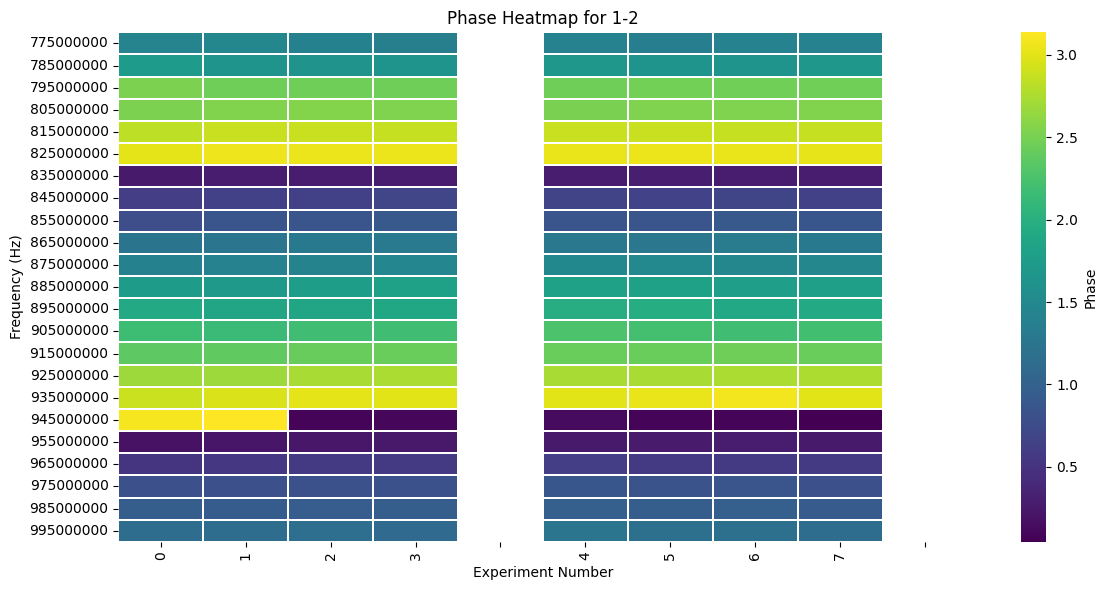

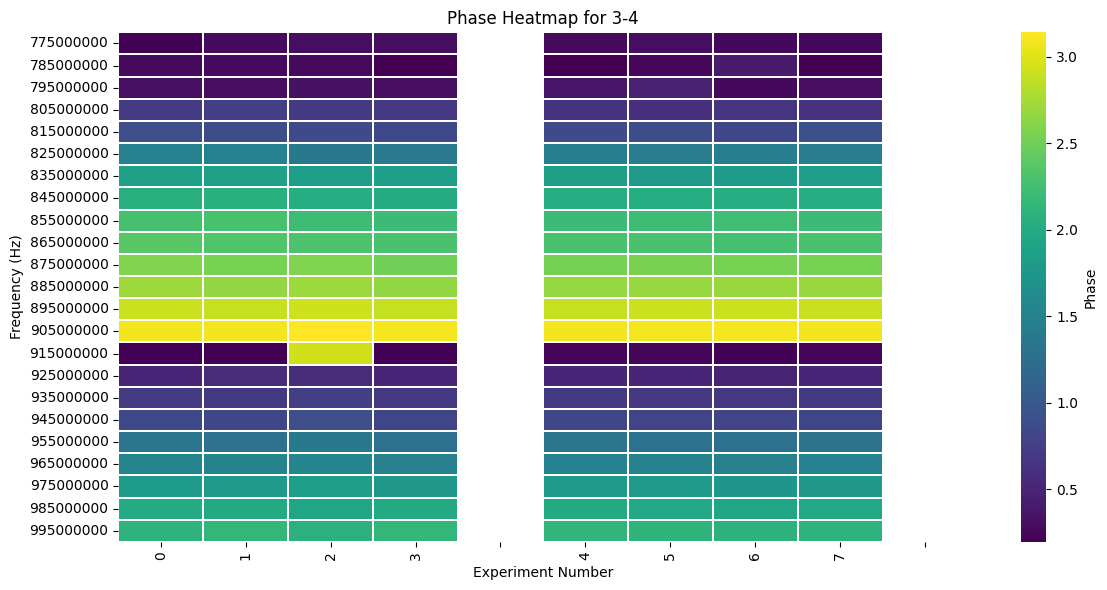

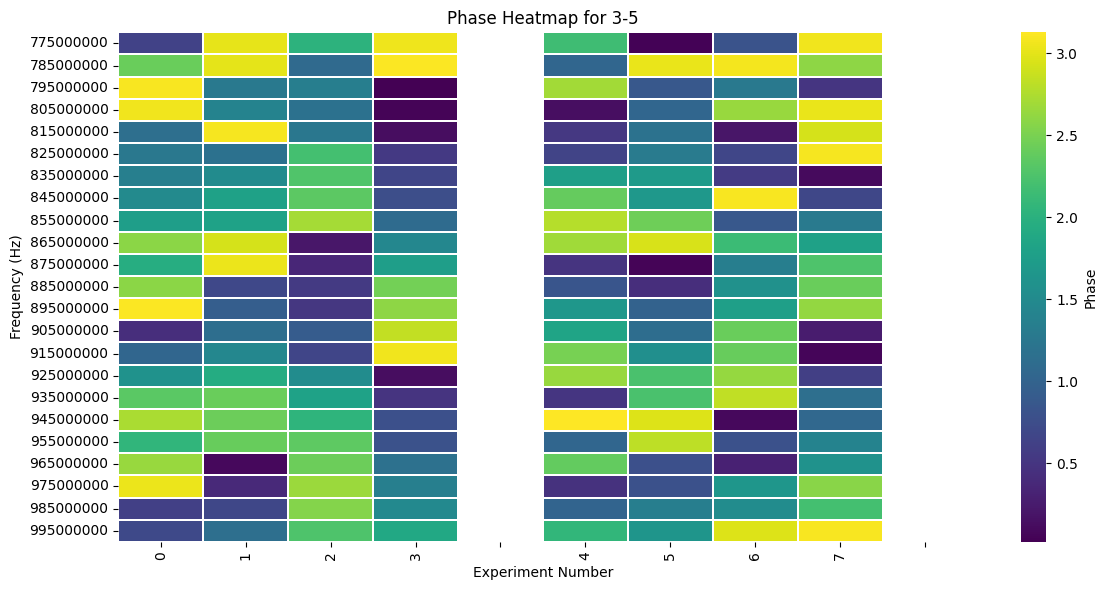

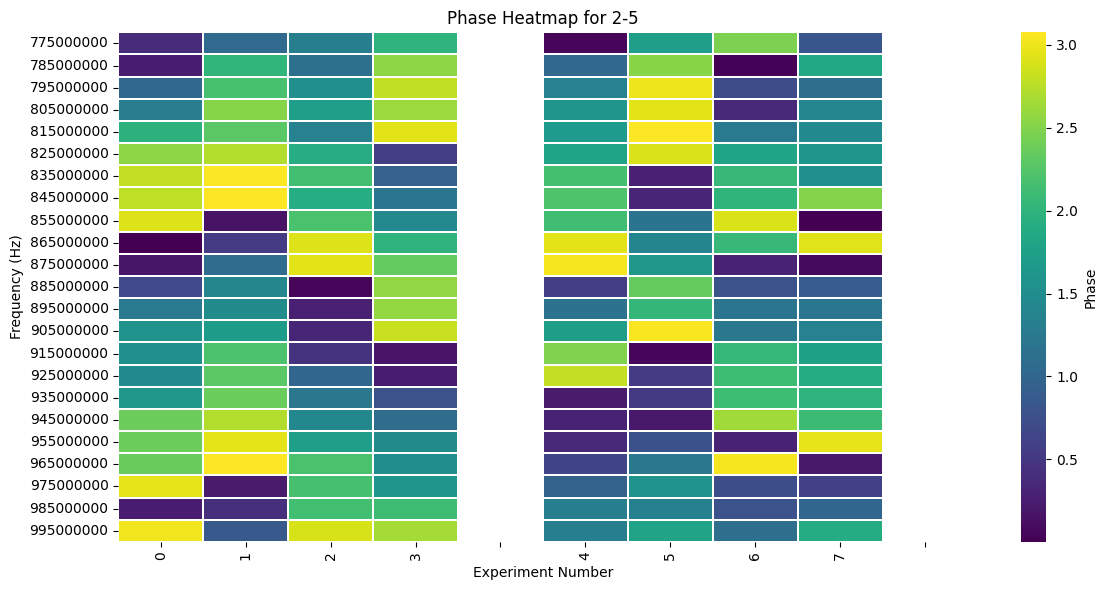

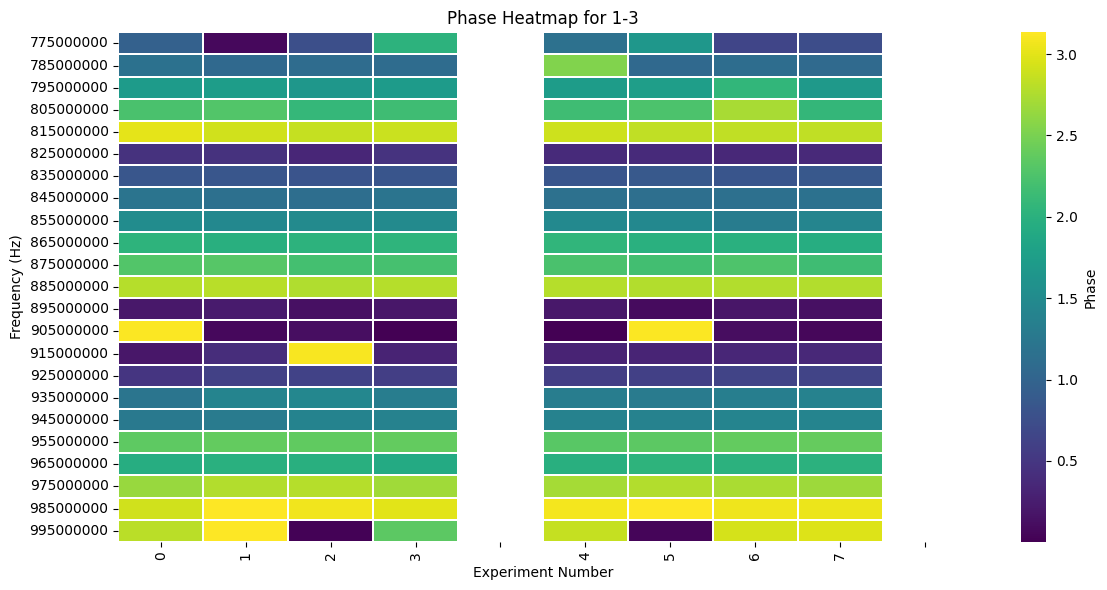

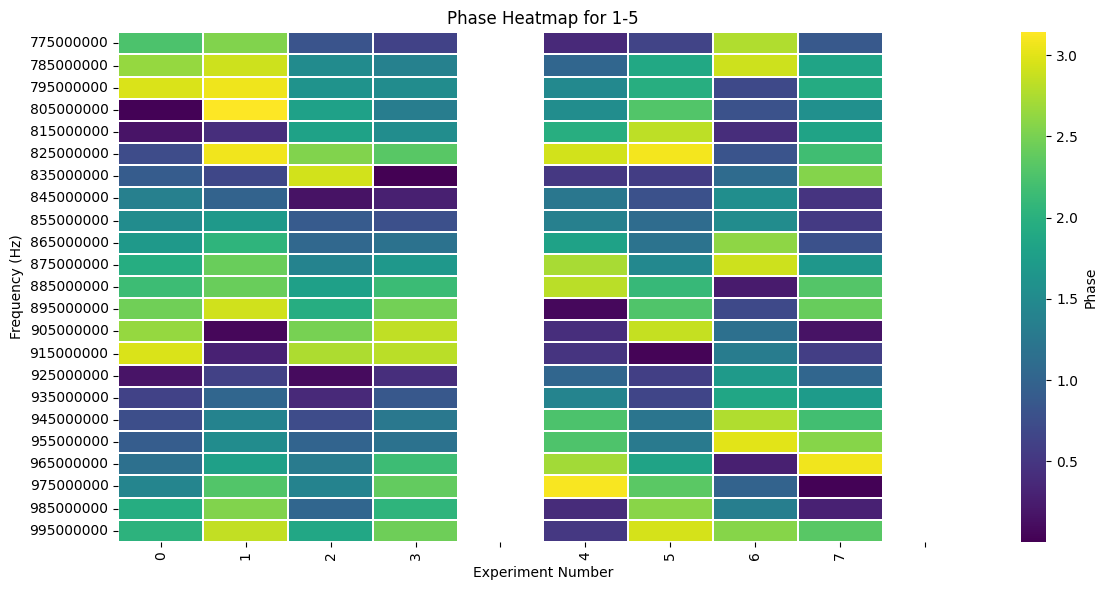

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phase_heatmaps(data):
    """
    data format:
    {
        freq: {
            exp_num: [ { "tagA-tagB": phase, ... } ]
        }
    }
    """

    # ---- Extract all tag pairs ----
    tag_pairs = set()
    for freq, exp_dict in data.items():
        for exp, tag_list in exp_dict.items():
            tag_pairs.update(tag_list[0].keys())

    frequencies = sorted(data.keys())
    experiment_numbers = sorted({exp for freq in data for exp in data[freq]})

    # ---- Build spacing-aware X-axis ----
    original_exps = experiment_numbers.copy()
    spaced_exps = []
    insert_positions = set()

    for i, exp in enumerate(experiment_numbers):
        spaced_exps.append(exp)
        if (i + 1) % 4 == 0:      # after every 4th experiment
            spaced_exps.append("")   # spacer label
            insert_positions.add(len(spaced_exps) - 1)

    # ---- Create heatmap for each tag ----
    for tag in tag_pairs:

        # Initialize heat matrix
        heat = np.full((len(frequencies), len(spaced_exps)), np.nan)

        for i, f in enumerate(frequencies):

            col = 0
            for j, exp in enumerate(original_exps):

                # Fill actual experiment column
                if exp in data[f]:
                    tag_dict = data[f][exp][0]
                    if tag in tag_dict:
                        heat[i, col] = tag_dict[tag]

                col += 1

                # If a spacer should be added here, skip one column
                if (j + 1) % 4 == 0:
                    col += 1

        # ---- Plot heatmap ----
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            heat,
            xticklabels=spaced_exps,
            yticklabels=frequencies,
            cmap="viridis",
            cbar_kws={"label": "Phase"},
            linewidths=0.2,
            linecolor="white"  # makes spacers more visible
        )

        plt.xlabel("Experiment Number")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"Phase Heatmap for {tag}")

        # Rotate labels
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show()

plot_phase_heatmaps(all_freqs)